Zaimplementuj aplikację szacującą czas ukończenia półmaratonu dla zadanych danych

1. Umieść dane w Digital Ocean Spaces

1. Napisz notebook, który będzie Twoim pipelinem do trenowania modelu
    * czyta dane z Digital Ocean Spaces
    * czyści je
    * trenuje model (dobierz odpowiednie metryki [feature selection])
    * nowa wersja modelu jest zapisywana lokalnie i do Digital Ocean Spaces

1. Aplikacja
    * opakuj model w aplikację streamlit
    * wdróż (deploy) aplikację za pomocą Digital Ocean AppPlatform 
    * wejściem jest pole tekstowe, w którym użytkownik się przedstawia, mówi o tym
    jaka jest jego płeć, wiek i tempo na 5km
    * jeśli użytkownik podał za mało danych, wyświetl informację o tym jakich danych brakuje
    * za pomocą LLM (OpenAI) wyłuskaj potrzebne dane, potrzebne dla Twojego modelu
    do określenia, do słownika (dictionary lub JSON)
    * tę część podepnij do Langfuse, aby zbierać metryki o skuteczności działania LLM'a



In [ ]:
!pip install --quiet boto3

In [ ]:
!pip install s3fs

In [216]:
import boto3
import os
from dotenv import load_dotenv
import pandas as pd
from itables import init_notebook_mode
from pycaret.regression import setup, compare_models, evaluate_model, plot_model
import mlflow
import matplotlib.pyplot as plt

In [217]:
load_dotenv()

s3 = boto3.client(
    "s3",
    aws_access_key_id=os.getenv("AWS_ACCESS_KEY_ID"),
    aws_secret_access_key=os.getenv("AWS_SECRET_ACCESS_KEY"),
    endpoint_url=os.getenv("AWS_ENDPOINT_URL_S3"),
)
BUCKET_NAME="jurek"

try:
    s3.head_bucket(Bucket=BUCKET_NAME)
    print("Połączenie z S3 działa poprawnie")
except Exception as e:
    print(f"Błąd połączenia z S3: {str(e)}")

Połączenie z S3 działa poprawnie


In [106]:
paginator = s3.get_paginator("list_objects_v2")
for page in paginator.paginate(Bucket=BUCKET_NAME, PaginationConfig={'PageSize': 10}):
    print("Nowa strona")
    for obj in page["Contents"]:
        print(obj["Key"])

Nowa strona
halfmarathons/
halfmarathons/dane_biegaczy.csv
halfmarathons/halfmarathon_wroclaw_2023__final.csv
halfmarathons/halfmarathon_wroclaw_2024__final.csv


In [107]:
df_2023 = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathons/halfmarathon_wroclaw_2023__final.csv", sep=";")
df_2024 = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathons/halfmarathon_wroclaw_2024__final.csv", sep=";")


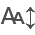

In [108]:
init_notebook_mode(all_interactive=True)

In [109]:
df_2023.head()

Miejsce  Numer startowy       Imię       Nazwisko   Miasto Kraj  \
0      1.0            1787     TOMASZ         GRYCKO      NaN  POL   
1      2.0               3  ARKADIUSZ  GARDZIELEWSKI  WROCŁAW  POL   
2      3.0            3832  KRZYSZTOF          HADAS   POZNAŃ  POL   
3      4.0             416     DAMIAN         DYDUCH    KĘPNO  POL   
4      5.0            8476      KAMIL      MAŃKOWSKI   MIRKÓW  POL   

                     Drużyna Płeć  Płeć Miejsce Kategoria wiekowa  ...  \
0     UKS BLIZA WŁADYSŁAWOWO    M           1.0               M30  ...   
1  ARKADIUSZGARDZIELEWSKI.PL    M           2.0               M30  ...   
2                        NaN    M           3.0               M20  ...   
3   AZS POLITECHNIKA OPOLSKA    M           4.0               M30  ...   
4            PARKRUN WROCŁAW    M           5.0               M20  ...   

   10 km Tempo  15 km Czas 15 km Miejsce Open  15 km Tempo  20 km Czas  \
0     2.926667    00:44:47                1.0     3.106667    01:01:43   
1     2.983333    00:45:26                2.0     3.143333    01:03:08   
2     3.123333    00:47:34                3.0     3.236667    01:05:09   
3     3.196667    00:48:49                5.0     3.330000    01:06:54   
4     3.276667    00:49:31                7.0     3.386667    01:07:27   

  20 km Miejsce Open  20 km Tempo  Tempo Stabilność      Czas     Tempo  
0                1.0     3.386667          0.031400  01:04:59  3.080509  
1                2.0     3.540000          0.038000  01:06:23  3.146875  
2                3.0     3.516667          0.024067  01:08:24  3.242475  
3                4.0     3.616667          0.025467  01:10:16  3.330963  
4                5.0     3.586667          0.023000  01:10:27  3.339654  

[5 rows x 27 columns]

In [110]:
df_2024.head()

Miejsce  Numer startowy     Imię    Nazwisko   Miasto Kraj  \
0      1.0             596  NIKODEM    DWORCZAK  KOŚCIAN  POL   
1      2.0             616  MATEUSZ      KACZOR    RADOM  POL   
2      3.0             154   PATRYK   KOZŁOWSKI    RADOM  POL   
3      4.0             591  DARIUSZ  BORATYŃSKI  WROCŁAW  POL   
4      5.0             521   SZYMON  DOROŻYŃSKI    LUBON  POL   

                               Drużyna Płeć  Płeć Miejsce Kategoria wiekowa  \
0                                  NaN    M           1.0               M20   
1                    RLTL OPTIMA RADOM    M           2.0               M20   
2                       RLTL-ZTE-RADOM    M           3.0               M20   
3          WOSIEK TEAM AZS AWF WROCŁAW    M           4.0               M20   
4  SZYMI TEAM AZS POLITECHNIKA OPOLSKA    M           5.0               M30   

   ...  10 km Tempo  15 km Czas 15 km Miejsce Open  15 km Tempo  20 km Czas  \
0  ...     2.920000    00:45:07                2.0     3.083333    01:00:33   
1  ...     2.920000    00:45:07                3.0     3.083333    01:00:38   
2  ...     2.920000    00:45:07                1.0     3.083333    01:00:59   
3  ...     3.110000    00:47:48                4.0     3.293333    01:05:40   
4  ...     3.153333    00:48:09                5.0     3.453333    01:06:05   

  20 km Miejsce Open  20 km Tempo  Tempo Stabilność      Czas     Tempo  
0                1.0     3.086667          0.007267  01:04:03  3.036265  
1                2.0     3.103333          0.008267  01:04:24  3.052856  
2                3.0     3.173333          0.012467  01:04:40  3.065497  
3                4.0     3.573333          0.028667  01:09:44  3.305681  
4                5.0     3.586667          0.039800  01:10:05  3.322272  

[5 rows x 27 columns]

In [111]:
# Dodać kolumnę z rokiem
df_2023['Rok'] = 2023
df_2024['Rok'] = 2024

# Sprawdź, czy oba DataFrame mają takie same nazwy kolumn
if list(df_2023.columns) == list(df_2024.columns):
    
    df_joined = pd.concat([df_2023, df_2024], ignore_index=True)
else:
    raise ValueError("Kolumny w DataFrame nie są takie same")


In [112]:
df_joined.columns

Index(['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa',
       'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas',
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność',
       'Czas', 'Tempo', 'Rok'],
      dtype='object')

In [113]:
# Snippet pomocniczy - zmiana czasu na sekundy

def convert_time_to_seconds(time):
    if pd.isnull(time) or time in ['DNS', 'DNF']:
        return None
    time = time.split(':')
    return int(time[0]) * 3600 + int(time[1]) * 60 + int(time[2])

In [114]:
for col in ["Czas", "5 km Czas", "10 km Czas", "15 km Czas", "20 km Czas"]:
    df_joined[col] = df_joined[col].apply(convert_time_to_seconds)

In [115]:
df_joined.head()

Miejsce  Numer startowy       Imię       Nazwisko   Miasto Kraj  \
0      1.0            1787     TOMASZ         GRYCKO      NaN  POL   
1      2.0               3  ARKADIUSZ  GARDZIELEWSKI  WROCŁAW  POL   
2      3.0            3832  KRZYSZTOF          HADAS   POZNAŃ  POL   
3      4.0             416     DAMIAN         DYDUCH    KĘPNO  POL   
4      5.0            8476      KAMIL      MAŃKOWSKI   MIRKÓW  POL   

                     Drużyna Płeć  Płeć Miejsce Kategoria wiekowa  ...  \
0     UKS BLIZA WŁADYSŁAWOWO    M           1.0               M30  ...   
1  ARKADIUSZGARDZIELEWSKI.PL    M           2.0               M30  ...   
2                        NaN    M           3.0               M20  ...   
3   AZS POLITECHNIKA OPOLSKA    M           4.0               M30  ...   
4            PARKRUN WROCŁAW    M           5.0               M20  ...   

   15 km Czas  15 km Miejsce Open  15 km Tempo  20 km Czas  \
0      2687.0                 1.0     3.106667      3703.0   
1      2726.0                 2.0     3.143333      3788.0   
2      2854.0                 3.0     3.236667      3909.0   
3      2929.0                 5.0     3.330000      4014.0   
4      2971.0                 7.0     3.386667      4047.0   

   20 km Miejsce Open  20 km Tempo  Tempo Stabilność    Czas     Tempo   Rok  
0                 1.0     3.386667          0.031400  3899.0  3.080509  2023  
1                 2.0     3.540000          0.038000  3983.0  3.146875  2023  
2                 3.0     3.516667          0.024067  4104.0  3.242475  2023  
3                 4.0     3.616667          0.025467  4216.0  3.330963  2023  
4                 5.0     3.586667          0.023000  4227.0  3.339654  2023  

[5 rows x 28 columns]

In [116]:
# Usuń zbędne kolumny
df_joined = df_joined.drop(columns=['Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć Miejsce', 'Kategoria wiekowa', 'Kategoria wiekowa Miejsce', 
       '5 km Miejsce Open', '10 km Miejsce Open', '15 km Miejsce Open', '20 km Miejsce Open'])

In [117]:
df_joined

Miejsce Płeć  Rocznik  5 km Czas  5 km Tempo  10 km Czas  10 km Tempo  \
0          1.0    M   1992.0      877.0    2.923333      1755.0     2.926667   
1          2.0    M   1986.0      888.0    2.960000      1783.0     2.983333   
2          3.0    M   1996.0      946.0    3.153333      1883.0     3.123333   
3          4.0    M   1988.0      971.0    3.236667      1930.0     3.196667   
4          5.0    M   1995.0      972.0    3.240000      1955.0     3.276667   
...        ...  ...      ...        ...         ...         ...          ...   
21952      NaN    K   1982.0        NaN         NaN         NaN          NaN   
21953      NaN    K   1998.0        NaN         NaN         NaN          NaN   
21954      NaN    M   1995.0        NaN         NaN         NaN          NaN   
21955      NaN    K   1991.0        NaN         NaN         NaN          NaN   
21956      NaN    M   1988.0        NaN         NaN         NaN          NaN   

       15 km Czas  15 km Tempo  20 km Czas  20 km Tempo  Tempo Stabilność  \
0          2687.0     3.106667      3703.0     3.386667          0.031400   
1          2726.0     3.143333      3788.0     3.540000          0.038000   
2          2854.0     3.236667      3909.0     3.516667          0.024067   
3          2929.0     3.330000      4014.0     3.616667          0.025467   
4          2971.0     3.386667      4047.0     3.586667          0.023000   
...           ...          ...         ...          ...               ...   
21952         NaN          NaN         NaN          NaN               NaN   
21953         NaN          NaN         NaN          NaN               NaN   
21954         NaN          NaN         NaN          NaN               NaN   
21955         NaN          NaN         NaN          NaN               NaN   
21956         NaN          NaN         NaN          NaN               NaN   

         Czas     Tempo   Rok  
0      3899.0  3.080509  2023  
1      3983.0  3.146875  2023  
2      4104.0  3.242475  2023  
3      4216.0  3.330963  2023  
4      4227.0  3.339654  2023  
...       ...       ...   ...  
21952     NaN       NaN  2024  
21953     NaN       NaN  2024  
21954     NaN       NaN  2024  
21955     NaN       NaN  2024  
21956     NaN       NaN  2024  

[21957 rows x 15 columns]

In [118]:
df_joined.isna().sum()

Miejsce             3507
Płeć                  11
Rocznik              485
5 km Czas           3546
5 km Tempo          3546
10 km Czas          3530
10 km Tempo         3562
15 km Czas          3529
15 km Tempo         3544
20 km Czas          3518
20 km Tempo         3535
Tempo Stabilność    3580
Czas                3507
Tempo               3507
Rok                    0
dtype: int64

In [119]:
df_joined = df_joined.dropna(subset=['Miejsce'])

In [120]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18450 entries, 0 to 19249
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Miejsce           18450 non-null  float64
 1   Płeć              18450 non-null  object 
 2   Rocznik           17965 non-null  float64
 3   5 km Czas         18411 non-null  float64
 4   5 km Tempo        18411 non-null  float64
 5   10 km Czas        18427 non-null  float64
 6   10 km Tempo       18395 non-null  float64
 7   15 km Czas        18428 non-null  float64
 8   15 km Tempo       18413 non-null  float64
 9   20 km Czas        18439 non-null  float64
 10  20 km Tempo       18422 non-null  float64
 11  Tempo Stabilność  18377 non-null  float64
 12  Czas              18450 non-null  float64
 13  Tempo             18450 non-null  float64
 14  Rok               18450 non-null  int64  
dtypes: float64(13), int64(1), object(1)
memory usage: 2.3+ MB


In [121]:
df_joined.isna().sum()

Miejsce               0
Płeć                  0
Rocznik             485
5 km Czas            39
5 km Tempo           39
10 km Czas           23
10 km Tempo          55
15 km Czas           22
15 km Tempo          37
20 km Czas           11
20 km Tempo          28
Tempo Stabilność     73
Czas                  0
Tempo                 0
Rok                   0
dtype: int64

In [122]:
(df_joined == 0).sum()

Miejsce              0
Płeć                 0
Rocznik             20
5 km Czas            1
5 km Tempo           1
10 km Czas           0
10 km Tempo          0
15 km Czas           0
15 km Tempo          0
20 km Czas           0
20 km Tempo          0
Tempo Stabilność     1
Czas                 0
Tempo                0
Rok                  0
dtype: int64

In [123]:
df_joined = df_joined[df_joined['5 km Czas'] != 0]

In [124]:
(df_joined == 0).sum()

Miejsce              0
Płeć                 0
Rocznik             20
5 km Czas            0
5 km Tempo           0
10 km Czas           0
10 km Tempo          0
15 km Czas           0
15 km Tempo          0
20 km Czas           0
20 km Tempo          0
Tempo Stabilność     1
Czas                 0
Tempo                0
Rok                  0
dtype: int64

In [125]:
df_joined = df_joined[df_joined['Tempo Stabilność'] != 0]

In [126]:
(df_joined == 0).sum()

Miejsce              0
Płeć                 0
Rocznik             20
5 km Czas            0
5 km Tempo           0
10 km Czas           0
10 km Tempo          0
15 km Czas           0
15 km Tempo          0
20 km Czas           0
20 km Tempo          0
Tempo Stabilność     0
Czas                 0
Tempo                0
Rok                  0
dtype: int64

In [127]:
# Mapowanie płci: 'K': 0, 'M': 1
df_joined['Płeć'] = df_joined['Płeć'].map({'K': 0, 'M': 1})

In [128]:
# Oblicz średnią wartość dla kolumny 'Rocznik', pomijając wartości równe 0.0
mean_rocznik = df_joined[df_joined['Rocznik'] != 0.0]['Rocznik'].mean()

# Zastąp wartości 0.0 i NaN w kolumnie 'Rocznik' średnią wartością
df_joined['Rocznik'] = df_joined['Rocznik'].replace(0.0, mean_rocznik)
df_joined['Rocznik'] = df_joined['Rocznik'].fillna(mean_rocznik)

In [129]:
# Oblicz średnią wartość dla kolumny '5 km Tempo' i '5 km Czas'
mean_5km_tempo = df_joined['5 km Tempo'].mean()
mean_5km_czas = df_joined['5 km Czas'].mean()

# Wypełnij brakujące wartości (NaN) średnią wartością
df_joined['5 km Tempo'] = df_joined['5 km Tempo'].fillna(mean_5km_tempo)
df_joined['5 km Czas'] = df_joined['5 km Czas'].fillna(mean_5km_czas)

In [130]:
(df_joined == 0).sum()


Miejsce                0
Płeć                5383
Rocznik                0
5 km Czas              0
5 km Tempo             0
10 km Czas             0
10 km Tempo            0
15 km Czas             0
15 km Tempo            0
20 km Czas             0
20 km Tempo            0
Tempo Stabilność       0
Czas                   0
Tempo                  0
Rok                    0
dtype: int64

In [131]:
df_joined.isna().sum()


Miejsce              0
Płeć                 0
Rocznik              0
5 km Czas            0
5 km Tempo           0
10 km Czas          23
10 km Tempo         55
15 km Czas          22
15 km Tempo         37
20 km Czas          11
20 km Tempo         28
Tempo Stabilność    73
Czas                 0
Tempo                0
Rok                  0
dtype: int64

In [132]:
df_training = df_joined.drop(columns=[
    '10 km Czas', "10 km Tempo", "15 km Czas", "15 km Tempo", "20 km Czas", "20 km Tempo", 
    "Tempo Stabilność", "Miejsce", "Tempo", "Rok", "5 km Tempo"])

In [133]:
df_training

Płeć      Rocznik  5 km Czas     Czas
0         1  1992.000000      877.0   3899.0
1         1  1986.000000      888.0   3983.0
2         1  1996.000000      946.0   4104.0
3         1  1988.000000      971.0   4216.0
4         1  1995.000000      972.0   4227.0
...     ...          ...        ...      ...
19245     0  1948.000000     2610.0  11987.0
19246     0  1978.000000     2526.0  12068.0
19247     0  1955.000000     2960.0  12138.0
19248     0  1981.000000     2808.0  12512.0
19249     1  1984.378978     3014.0  12754.0

[18448 rows x 4 columns]

In [134]:
MLFLOW_EXPERIMENT_NAME = 'HalfMarathon'
MLFLOW_TAGS = {'data': 'Wroc_23_24', 'library': 'pycaret', 'run_type': 'with_outliers'}

mlflow.set_tracking_uri("http://localhost:5000")

In [136]:

exp = setup(
    data=df_training, 
    target='Czas', 
    session_id=321, 
    verbose=False,
    log_experiment=True,
    log_plots=True,
    experiment_name=MLFLOW_EXPERIMENT_NAME,
    experiment_custom_tags=MLFLOW_TAGS,
)

In [137]:
best_model = exp.compare_models(experiment_custom_tags={"step": "compare"})

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,299.8375,169345.6311,411.2788,0.8860,0.0521,0.0392,0.4250
lightgbm,Light Gradient Boosting Machine,302.5590,172961.1591,415.6376,0.8835,0.0527,0.0396,0.2790
catboost,CatBoost Regressor,302.2569,174109.9807,416.9835,0.8828,0.0528,0.0395,3.5370
llar,Lasso Least Angle Regression,302.3700,180523.3156,423.9390,0.8785,0.0528,0.0395,0.0760
lr,Linear Regression,302.3566,180532.2500,423.9500,0.8785,0.0528,0.0395,2.7320
br,Bayesian Ridge,302.3677,180520.6578,423.9360,0.8785,0.0528,0.0395,0.0840
lasso,Lasso Regression,302.3700,180523.3328,423.9390,0.8785,0.0528,0.0395,0.0420
lar,Least Angle Regression,302.3566,180532.2406,423.9500,0.8785,0.0528,0.0395,0.0720
en,Elastic Net,302.3687,180521.8578,423.9373,0.8785,0.0528,0.0395,0.0530
ridge,Ridge Regression,302.3566,180532.2438,423.9500,0.8785,0.0528,0.0395,0.0370


2025/01/16 12:51:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 12:51:10 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting Regressor at: http://localhost:5000/#/experiments/369376800093570612/runs/1dcbf03b76f14493b6a8951f99a67327.
2025/01/16 12:51:10 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.
2025/01/16 12:51:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 12:51:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://localhost:5000/#/experiments/369376800093570612/runs/3fa984d059e84d2eac8607c1ee659d39.
2025/01/16 12:51:13 INFO mlflow.tracking._tracking_

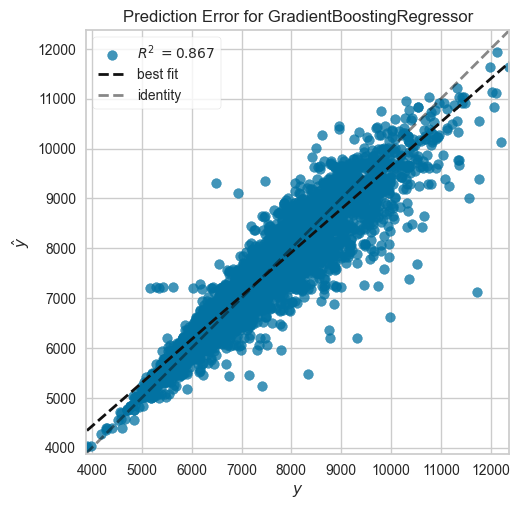

In [138]:
exp.plot_model(best_model, plot='error')

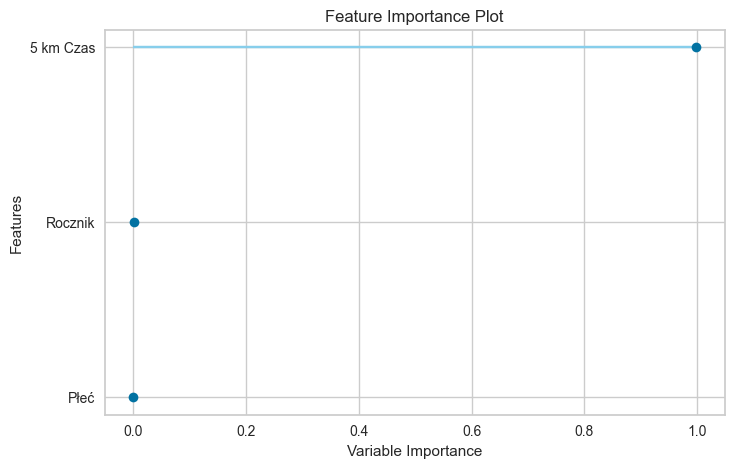

In [139]:
exp.plot_model(best_model, plot='feature')

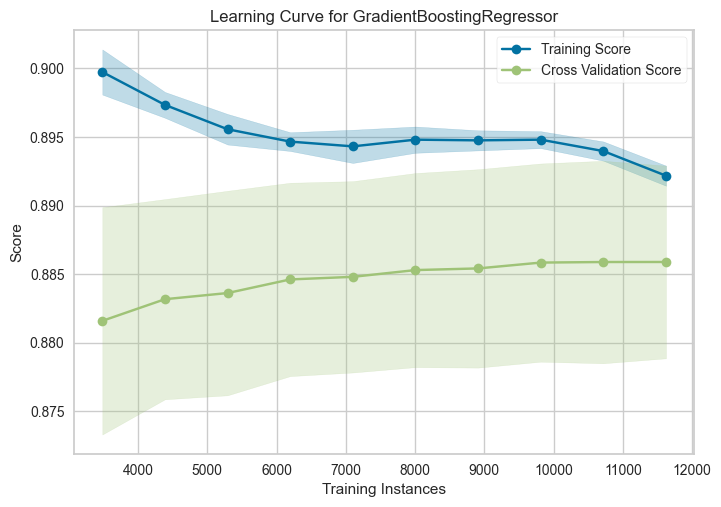

In [140]:
exp.plot_model(best_model, plot='learning')

In [141]:
exp.predict_model(best_model)
best_final_model = exp.finalize_model(best_model, experiment_custom_tags={"step": "final"})
exp.save_model(best_final_model, 'halfmarathon-basic-model')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,309.4896,195693.2657,442.3723,0.8670,0.0558,0.0402


2025/01/16 12:52:36 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 12:52:37 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting Regressor at: http://localhost:5000/#/experiments/369376800093570612/runs/56e691f801084874a0f950f01484ebe0.
2025/01/16 12:52:37 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['Płeć', 'Rocznik', '5 km Czas'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('clean_column_names',
                  TransformerWrapper(transformer=CleanColumnNames())),
                 ('actual_estimator',
                  GradientBoostingRegressor(random_state=321))]),
 'halfmarathon-basic-model.pkl')

In [142]:
df_training.columns

Index(['Płeć', 'Rocznik', '5 km Czas', 'Czas'], dtype='object')

In [147]:
# Testtowanie modelu

model_name = "HalfMarathon_predictor"
alias = "production"

loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}@{alias}")

input_data = {
    'Płeć': 1,
    'Rocznik': 1980,
    '5 km Czas': 1700, #### Tu wpisz swój czas na 5 km w sekundach ####
}

czas_hm = loaded_model.predict(pd.DataFrame([input_data]))[0]
czas_hm / 60

125.3785809377085

In [148]:
# Sprawdźmy czy nasz model nauczył się tylko prostego działania arytmetycznego

mean_czas = df_training['Czas'].mean()
mean_5km_czas = df_training['5 km Czas'].mean()
k = mean_czas / mean_5km_czas
Twoj_Czas_Na_5km = 1700 #### Tu wpisz ten sam czas co w komórce wyżej
k * Twoj_Czas_Na_5km / 60

125.23565226777036

### Okazuje się, że mój naiwny model jest tylko odrobinę mniej dokładny od Gradient Boosting Regressor.
Widzimy, że model właściwie pominął dane o wieku i płci zawodników. Teraz zachowuje się tak, że aplikacja byłaby użyteczna tylko dla właśnie w tej chwili biegnących zawodników, którzy przekraczają piąty kilometr. Moim znaniem będzie to nudna aplikacja i trzeba zmienić podejście do danych. 
- Zastanwia mnie po co ktoś wprowadził coś takiego dziwnego jak kategorie wiekowe.
- Może ciekawiej będzie przewidzieć czas w półmaratonie na podstawie płci, wieku i poziomu sportowego.

Czyli zacznę właściwie od początku.

In [149]:
df_2023 = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathons/halfmarathon_wroclaw_2023__final.csv", sep=";")
df_2024 = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathons/halfmarathon_wroclaw_2024__final.csv", sep=";")

In [150]:
if list(df_2023.columns) == list(df_2024.columns):
    
    df_joined_2 = pd.concat([df_2023, df_2024], ignore_index=True)
else:
    raise ValueError("Kolumny w DataFrame nie są takie same")

In [151]:
df_joined_2.columns

Index(['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć', 'Płeć Miejsce', 'Kategoria wiekowa',
       'Kategoria wiekowa Miejsce', 'Rocznik', '5 km Czas',
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', 'Tempo Stabilność',
       'Czas', 'Tempo'],
      dtype='object')

In [152]:
df_joined_2 = df_joined_2.drop(columns=['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć Miejsce', 
       'Kategoria wiekowa Miejsce', 
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', "Tempo"
       ])

In [153]:
df_joined_2.sample(10)

Płeć Kategoria wiekowa  Rocznik 5 km Czas  Tempo Stabilność      Czas
7371     M               M40   1983.0  00:32:28          0.140933  02:31:12
21679    K               K30   1989.0       NaN               NaN       DNS
11412    M               M30   1994.0  00:24:43          0.045467  01:49:28
15441    M               M20   2000.0  00:29:46          0.034067  02:09:05
4809     M               M40   1977.0  00:27:06          0.084800  02:04:32
7846     K               K20   1996.0  00:30:34          0.282733  02:43:19
3760     M               M30   1989.0  00:26:40          0.062400  01:58:32
6964     M               M60   1960.0  00:31:01          0.107933  02:24:47
16677    M               M60   1955.0  00:30:01          0.074533  02:16:46
13996    K               K30   1993.0  00:27:30          0.043667  02:01:13

In [154]:
(df_joined_2 == 0).sum()


Płeć                  0
Kategoria wiekowa     0
Rocznik              31
5 km Czas             0
Tempo Stabilność      1
Czas                  0
dtype: int64

In [155]:
df_joined_2.isna().sum()

Płeć                   11
Kategoria wiekowa      31
Rocznik               485
5 km Czas            3546
Tempo Stabilność     3580
Czas                 2055
dtype: int64

In [156]:
df_joined_2 = df_joined_2.dropna(subset=['Czas'])

In [157]:
df_joined_2 = df_joined_2.dropna(subset=['Kategoria wiekowa'])

In [158]:
df_joined_2 = df_joined_2.drop(columns=['Rocznik'])

In [159]:
df_joined_2 = df_joined_2.dropna(subset=['5 km Czas'])

In [160]:
df_joined_2.isna().sum()

Płeć                  0
Kategoria wiekowa     0
5 km Czas             0
Tempo Stabilność     33
Czas                  0
dtype: int64

In [161]:
(df_joined_2 == 0).sum()

Płeć                 0
Kategoria wiekowa    0
5 km Czas            0
Tempo Stabilność     1
Czas                 0
dtype: int64

In [162]:
# Oblicz średnią wartość dla kolumny 'Tempo Stabilność', pomijając wartości równe 0.0
mean_stabilonsc = df_joined_2[df_joined_2['Tempo Stabilność'] != 0.0]['Tempo Stabilność'].mean()

# Zastąp wartości 0.0 i NaN w kolumnie 'Tempo Stabilność' średnią wartością
df_joined_2['Tempo Stabilność'] = df_joined_2['Tempo Stabilność'].replace(0.0, mean_stabilonsc)
df_joined_2['Tempo Stabilność'] = df_joined_2['Tempo Stabilność'].fillna(mean_stabilonsc)

In [163]:
df_joined_2

Płeć Kategoria wiekowa 5 km Czas  Tempo Stabilność      Czas
0        M               M30  00:14:37          0.031400  01:04:59
1        M               M30  00:14:48          0.038000  01:06:23
2        M               M20  00:15:46          0.024067  01:08:24
3        M               M30  00:16:11          0.025467  01:10:16
4        M               M20  00:16:12          0.023000  01:10:27
...    ...               ...       ...               ...       ...
19245    K               K70  00:43:30          0.052148  03:19:47
19246    K               K40  00:42:06          0.162733  03:21:08
19247    K               K60  00:49:20         -0.029333  03:22:18
19248    K               K40  00:46:48          0.057000  03:28:32
19249    M               M40  00:50:14         -0.046400  03:32:34

[18393 rows x 5 columns]

In [164]:
for col in ["5 km Czas", "Czas"]:
    df_joined_2[col] = df_joined_2[col].apply(convert_time_to_seconds)

In [165]:
df_joined_2

Płeć Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas
0        M               M30        877          0.031400   3899
1        M               M30        888          0.038000   3983
2        M               M20        946          0.024067   4104
3        M               M30        971          0.025467   4216
4        M               M20        972          0.023000   4227
...    ...               ...        ...               ...    ...
19245    K               K70       2610          0.052148  11987
19246    K               K40       2526          0.162733  12068
19247    K               K60       2960         -0.029333  12138
19248    K               K40       2808          0.057000  12512
19249    M               M40       3014         -0.046400  12754

[18393 rows x 5 columns]

array([[<Axes: title={'center': 'Czas'}>]], dtype=object)

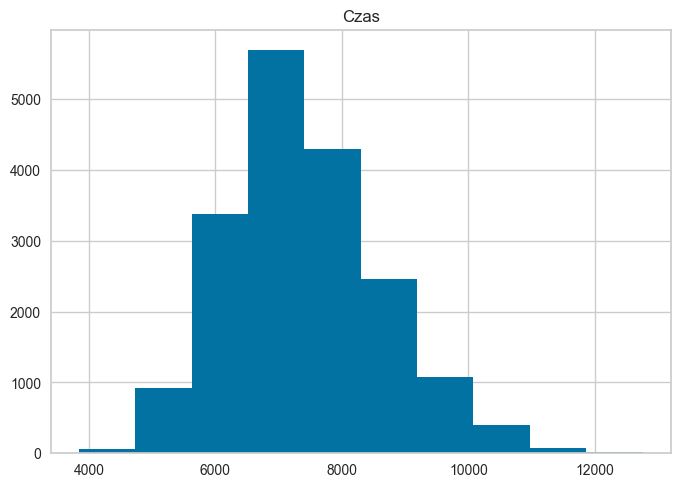

In [166]:
df_joined_2.hist("Czas")

In [167]:
df_joined_2["Kategoria wiekowa"].value_counts()

Kategoria wiekowa
M40    4367
M30    4193
M20    2393
K30    1895
K40    1833
M50    1463
K20    1126
M60     520
K50     428
K60      81
M70      80
K70      11
M80       3
Name: count, dtype: int64

In [168]:
# Spróbuję nauczyć dwa modele, oddzielnie dla Kobiet i Mężczyzn
df_k = df_joined_2[df_joined_2['Płeć'] == 'K'].drop(columns=['Płeć']).reset_index(drop=True)
df_m = df_joined_2[df_joined_2['Płeć'] == 'M'].drop(columns=['Płeć']).reset_index(drop=True)

In [169]:
df_m

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas
0                   M30        877          0.031400   3899
1                   M30        888          0.038000   3983
2                   M20        946          0.024067   4104
3                   M30        971          0.025467   4216
4                   M20        972          0.023000   4227
...                 ...        ...               ...    ...
13014               M30       2603          0.052148  11460
13015               M50       2297          0.171667  11536
13016               M60       2525          0.062867  11643
13017               M50       2068          0.206133  11769
13018               M40       3014         -0.046400  12754

[13019 rows x 4 columns]

In [170]:
MLFLOW_EXPERIMENT_NAME = 'HalfMarathon'
MLFLOW_TAGS = {'data': 'Female', 'library': 'pycaret', 'run_type': 'age_category'}

mlflow.set_tracking_uri("http://localhost:5000")

In [171]:
exp_k = setup(
    data=df_k,
    target='Czas',
    session_id=321,
    verbose=True,
    categorical_features=['Kategoria wiekowa'],
    ordinal_features={'Kategoria wiekowa': ['K70', 'K60', 'K50', 'K40', 'K30', 'K20']},
    normalize=True,
    log_experiment=True,
    log_plots=True,
    experiment_name=MLFLOW_EXPERIMENT_NAME,
    experiment_custom_tags=MLFLOW_TAGS,
)

Description,Value
Session id,321
Target,Czas
Target type,Regression
Original data shape,"(5374, 4)"
Transformed data shape,"(5374, 9)"
Transformed train set shape,"(3761, 9)"
Transformed test set shape,"(1613, 9)"
Ordinal features,1
Numeric features,2
Categorical features,1


In [172]:
best_model_k = exp_k.compare_models(experiment_custom_tags={"step": "compare"})

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,102.6438,28601.4100,163.2863,0.9780,0.0187,0.0125,0.3900
lightgbm,Light Gradient Boosting Machine,104.8405,29175.4341,165.1798,0.9776,0.0194,0.0128,0.3860
rf,Random Forest Regressor,104.2997,30441.0609,169.2577,0.9765,0.0194,0.0126,0.8860
et,Extra Trees Regressor,106.2505,32620.5393,175.7038,0.9747,0.0202,0.0129,0.7370
catboost,CatBoost Regressor,100.6226,32888.0929,176.2101,0.9745,0.0205,0.0123,2.4610
huber,Huber Regressor,93.9863,32779.6585,167.6634,0.9745,0.0183,0.0113,0.1210
br,Bayesian Ridge,95.2682,32886.7617,168.5947,0.9744,0.0184,0.0115,0.1000
llar,Lasso Least Angle Regression,95.3374,32886.7917,168.6168,0.9744,0.0184,0.0115,0.1670
lar,Least Angle Regression,95.2623,32886.5279,168.5911,0.9744,0.0184,0.0115,0.1990
ridge,Ridge Regression,95.2892,32886.2036,168.6048,0.9744,0.0184,0.0115,0.1990


2025/01/16 13:03:10 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 13:03:11 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting Regressor at: http://localhost:5000/#/experiments/369376800093570612/runs/24a3087b899d48ada90682b860b828da.
2025/01/16 13:03:11 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.
2025/01/16 13:03:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 13:03:12 INFO mlflow.tracking._tracking_service.client: 🏃 View run Light Gradient Boosting Machine at: http://localhost:5000/#/experiments/369376800093570612/runs/c4cc96d1649e448ba331818029a9aebd.
2025/01/16 13:03:12 INFO mlflow.tracking._tracking_

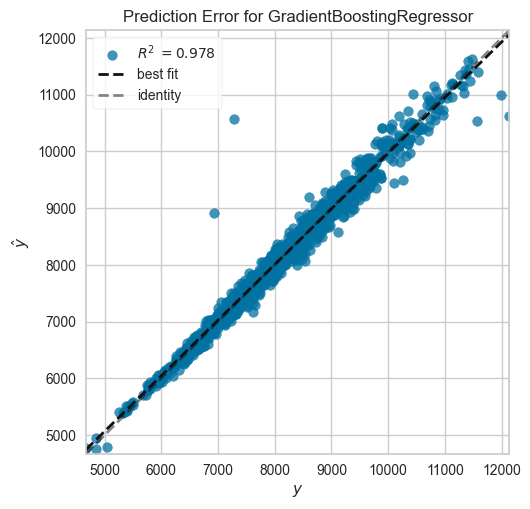

In [173]:
exp_k.plot_model(best_model_k, plot='error')

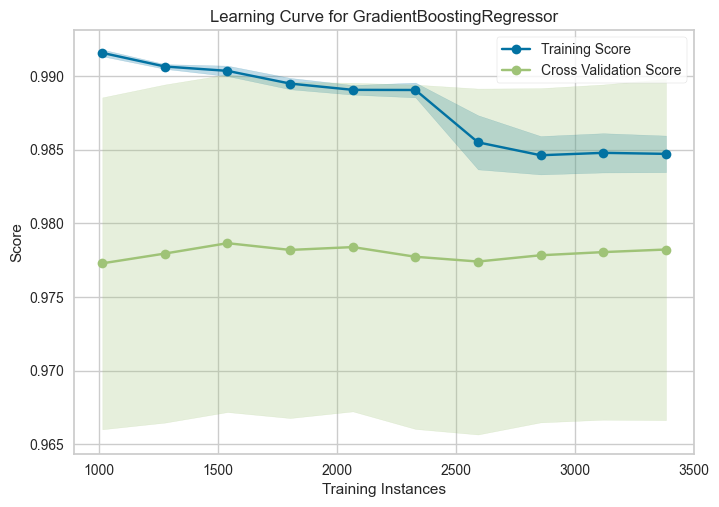

In [174]:
exp_k.plot_model(best_model_k, plot='learning')

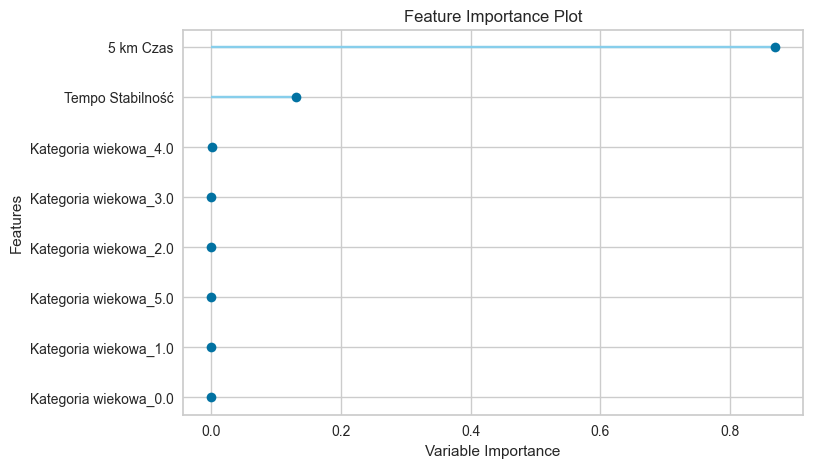

In [175]:
exp_k.plot_model(best_model_k, plot='feature')

In [176]:
exp_k.predict_model(best_model_k)
best_final_model_k = exp_k.finalize_model(best_model_k, experiment_custom_tags={"step": "final"})
exp_k.save_model(best_final_model_k, 'halfmarathon-female-model')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Gradient Boosting Regressor,105.5138,29767.7626,172.5334,0.9778,0.0199,0.0128


2025/01/16 13:04:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 13:04:30 INFO mlflow.tracking._tracking_service.client: 🏃 View run Gradient Boosting Regressor at: http://localhost:5000/#/experiments/369376800093570612/runs/0ec02713a0b145a8a01fe5c613878269.
2025/01/16 13:04:30 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['5 km Czas', 'Tempo Stabilność'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Kategoria wiekowa'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Kategoria wiekowa'],
                                     tran...
                  TransformerWrapper(include=['Kategoria wiekowa'],
                                     transformer=OneHotEncoder(cols=['Kategoria '
                                                                     'wiekowa'],
                                                               handle_missing='return_nan',
                                                               use_cat_names=True))),
            

In [177]:
model_name = "HalfMarathon_female_predictor"
alias = "production"

loaded_model = mlflow.pyfunc.load_model(f"models:/{model_name}@{alias}")

input_data = {
    'Kategoria wiekowa': "K30",
    '5 km Czas': 1200, #### Tu wpisz swój czas na 5 km w sekundach ####
    'Tempo Stabilność': 0.05, 
}

czas_hm = loaded_model.predict(pd.DataFrame([input_data]))[0]
czas_hm / 60

89.75096905136888

### Jednak tak przygotowane dane niewiele zmieniły w zachowaniu modelu. 
Nadal używa prostego równania arytmetycznego do wyliczenia czasu półmaratonu biorąc pod uwagę czas na 5 kilometrze ze zbyt dużą wagą w porównaniu z innymi danymi.

In [179]:
from pycaret.clustering import *

In [180]:
MLFLOW_EXPERIMENT_NAME = 'HalfMarathon'
MLFLOW_TAGS = {'data': 'Female', 'library': 'pycaret', 'run_type': 'clastering'}

exp_women = setup(
    data=df_k, 
    normalize=True, 
    categorical_features=['Kategoria wiekowa'],
    ordinal_features={'Kategoria wiekowa': ['K20', 'K30', 'K40', 'K50', 'K60']},
    session_id=321, 
    log_experiment=True, 
    log_plots=True,
    experiment_name=MLFLOW_EXPERIMENT_NAME, 
    experiment_custom_tags=MLFLOW_TAGS,
)

Description,Value
Session id,321
Original data shape,"(5374, 4)"
Transformed data shape,"(5374, 9)"
Ordinal features,1
Numeric features,3
Categorical features,1
Preprocess,True
Imputation type,simple
Numeric imputation,mean
Categorical imputation,mode


In [181]:
kmeans_women = create_model('kmeans', num_clusters=3, random_state=321, n_init=20, max_iter=300, tol=0.0001)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3558,1243.6057,1.5204,0,0,0


2025/01/16 13:06:14 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 13:06:14 INFO mlflow.tracking._tracking_service.client: 🏃 View run K-Means Clustering at: http://localhost:5000/#/experiments/369376800093570612/runs/03e60d137e0e4ca29f6485191d34f658.
2025/01/16 13:06:14 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.


In [182]:
plot_model(kmeans_women, plot='cluster')

#### Tu już widać, że w dwóch klastrach jest po jednej kategorii wiekowej, a w trzecim reszta.

In [183]:
clustered_data_women = assign_model(kmeans_women)

In [184]:
clustered_data_women

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas    Cluster
0                  K20       1038          0.025533   4520  Cluster 1
1                  K30       1038          0.037400   4614  Cluster 0
2                  K30       1072          0.044800   4840  Cluster 0
3                  K30       1139          0.031933   4977  Cluster 0
4                  K20       1188          0.023600   5112  Cluster 1
...                ...        ...               ...    ...        ...
5369               K40       2396          0.178267  11866  Cluster 2
5370               K70       2610          0.052148  11987  Cluster 1
5371               K40       2526          0.162733  12068  Cluster 2
5372               K60       2960         -0.029333  12138  Cluster 1
5373               K40       2808          0.057000  12512  Cluster 2

[5374 rows x 5 columns]

In [185]:
plot_model(kmeans_women, plot='tsne')

In [186]:
clustered_data_women.groupby(['Cluster', 'Kategoria wiekowa']).size().reset_index(name='Count')

Cluster Kategoria wiekowa  Count
0   Cluster 0               K20      0
1   Cluster 0               K30   1895
2   Cluster 0               K40      0
3   Cluster 0               K50      0
4   Cluster 0               K60      0
5   Cluster 0               K70      0
6   Cluster 1               K20   1126
7   Cluster 1               K30      0
8   Cluster 1               K40      0
9   Cluster 1               K50    428
10  Cluster 1               K60     81
11  Cluster 1               K70     11
12  Cluster 2               K20      0
13  Cluster 2               K30      0
14  Cluster 2               K40   1833
15  Cluster 2               K50      0
16  Cluster 2               K60      0
17  Cluster 2               K70      0

### Takie klastry również nie wprowadzają żadnych istotnych informacji
- w **Claster 0** jest tylko kategoria **K30**
- w **Claster 2** jest tylko kategoria **K40**
- w **Claster 1** są pozostałe kategorie wiekowe

Taki podział nic nie wnosi. Potrzebne jest inne podejście.

### Znormalizujemy wszystkie dane liczbowe, ale w każdej kategorii wiekowej oddzielnie
Taka metoda może znormalizować nam czasy. Przesuną się one tak, że nie będzie miało znaczenia w jakim wieku jest biegacz i jakiej jest płci. Najważniejszy będzie jego czas, czyli poziom sportowy. I tak podzielimy tych biegaczy na klastry - czyli, mam nadzieję, na poziomy wytrenowania.

In [187]:
df_joined_2 = df_joined_2.drop(columns=['Płeć'])
df_joined_2

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas
0                   M30        877          0.031400   3899
1                   M30        888          0.038000   3983
2                   M20        946          0.024067   4104
3                   M30        971          0.025467   4216
4                   M20        972          0.023000   4227
...                 ...        ...               ...    ...
19245               K70       2610          0.052148  11987
19246               K40       2526          0.162733  12068
19247               K60       2960         -0.029333  12138
19248               K40       2808          0.057000  12512
19249               M40       3014         -0.046400  12754

[18393 rows x 4 columns]

In [188]:
from sklearn.preprocessing import StandardScaler

In [189]:
def normalize_features(group):
    scaler = StandardScaler()
    group[['Czas', '5 km Czas', 'Tempo Stabilność']] = scaler.fit_transform(
        group[['Czas', '5 km Czas', 'Tempo Stabilność']]
    )
    return group

# Normalizacja danych w grupach
df_normalized = df_joined_2.groupby('Kategoria wiekowa').apply(normalize_features)
df_normalized

Kategoria wiekowa  5 km Czas  Tempo Stabilność  \
Kategoria wiekowa                                                        
K20               14                  K20  -3.364442         -0.573708   
                  131                 K20  -2.707903         -0.611205   
                  147                 K20  -2.782311         -0.311224   
                  161                 K20  -2.795442         -0.344843   
                  325                 K20  -2.690395         -0.104340   
...                                   ...        ...               ...   
M70               19166               M70   1.958866          0.836295   
                  19231               M70   2.285057          1.731097   
M80               7771                M80  -0.113938         -0.325077   
                  8136                M80   1.277733          1.354488   
                  18046               M80  -1.163795         -1.029411   

                             Czas  
Kategoria wiekowa                  
K20               14    -2.991800  
                  131   -2.482340  
                  147   -2.462546  
                  161   -2.433287  
                  325   -2.232773  
...                           ...  
M70               19166  1.779288  
                  19231  2.251421  
M80               7771  -0.357146  
                  8136   1.363619  
                  18046 -1.006473  

[18393 rows x 4 columns]

In [190]:
# Usunięcie kolumny 'Kategoria wiekowa' przed klastrowaniem  
df_for_clustering = df_normalized.drop(columns=['Kategoria wiekowa'])

In [191]:
MLFLOW_EXPERIMENT_NAME = 'HalfMarathon'
MLFLOW_TAGS = {'data': 'Wroc_23_24', 'library': 'pycaret', 'run_type': 'clastering_no_age'}

setup(
    data=df_for_clustering,
    normalize=False,
    session_id=321,
    log_experiment=True,
    log_plots=True,
    experiment_name=MLFLOW_EXPERIMENT_NAME,
    experiment_custom_tags=MLFLOW_TAGS,
)

Description,Value
Session id,321
Original data shape,"(18393, 3)"
Transformed data shape,"(18393, 3)"
Numeric features,3
Preprocess,True
Imputation type,simple
Numeric imputation,mean
Categorical imputation,mode
CPU Jobs,-1
Use GPU,False


In [192]:
kmeans_model = create_model('kmeans', num_clusters=3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3667,15076.8842,0.9386,0,0,0


2025/01/16 13:11:33 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 13:11:33 INFO mlflow.tracking._tracking_service.client: 🏃 View run K-Means Clustering at: http://localhost:5000/#/experiments/369376800093570612/runs/2b8297772ed544a28612c98999767ae5.
2025/01/16 13:11:33 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.


In [193]:
clustered_data = assign_model(kmeans_model)


In [194]:
# Resetowanie indeksów w obu dataframe'ach
clustered_data = clustered_data.reset_index(drop=True)
df_joined_2 = df_joined_2.reset_index(drop=True)

# Przypisanie kolumny 'Cluster' (z klasteryzacji) do danych przed normalizacją
df_joined_2['Cluster'] = clustered_data['Cluster']

In [195]:
df_joined_2

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas    Cluster
0                   M30        877          0.031400   3899  Cluster 1
1                   M30        888          0.038000   3983  Cluster 1
2                   M20        946          0.024067   4104  Cluster 1
3                   M30        971          0.025467   4216  Cluster 1
4                   M20        972          0.023000   4227  Cluster 1
...                 ...        ...               ...    ...        ...
18388               K70       2610          0.052148  11987  Cluster 0
18389               K40       2526          0.162733  12068  Cluster 0
18390               K60       2960         -0.029333  12138  Cluster 2
18391               K40       2808          0.057000  12512  Cluster 0
18392               M40       3014         -0.046400  12754  Cluster 1

[18393 rows x 5 columns]

In [196]:
cluster_summary = df_joined_2.groupby(['Cluster', 'Kategoria wiekowa']).size().reset_index(name='Count')

In [197]:
cluster_summary

Cluster Kategoria wiekowa  Count
0   Cluster 0               K20    200
1   Cluster 0               K30    317
2   Cluster 0               K40    325
3   Cluster 0               K50     85
4   Cluster 0               K60     23
5   Cluster 0               K70      3
6   Cluster 0               M20    370
7   Cluster 0               M30    642
8   Cluster 0               M40    740
9   Cluster 0               M50    248
10  Cluster 0               M60     89
11  Cluster 0               M70     11
12  Cluster 0               M80      1
13  Cluster 1               K20    467
14  Cluster 1               K30    752
15  Cluster 1               K40    689
16  Cluster 1               K50    160
17  Cluster 1               K60     37
18  Cluster 1               K70      5
19  Cluster 1               M20   1041
20  Cluster 1               M30   1822
21  Cluster 1               M40   1836
22  Cluster 1               M50    621
23  Cluster 1               M60    218
24  Cluster 1               M70     26
25  Cluster 1               M80      2
26  Cluster 2               K20    459
27  Cluster 2               K30    826
28  Cluster 2               K40    819
29  Cluster 2               K50    183
30  Cluster 2               K60     21
31  Cluster 2               K70      3
32  Cluster 2               M20    982
33  Cluster 2               M30   1729
34  Cluster 2               M40   1791
35  Cluster 2               M50    594
36  Cluster 2               M60    213
37  Cluster 2               M70     43

In [198]:
import seaborn as sns

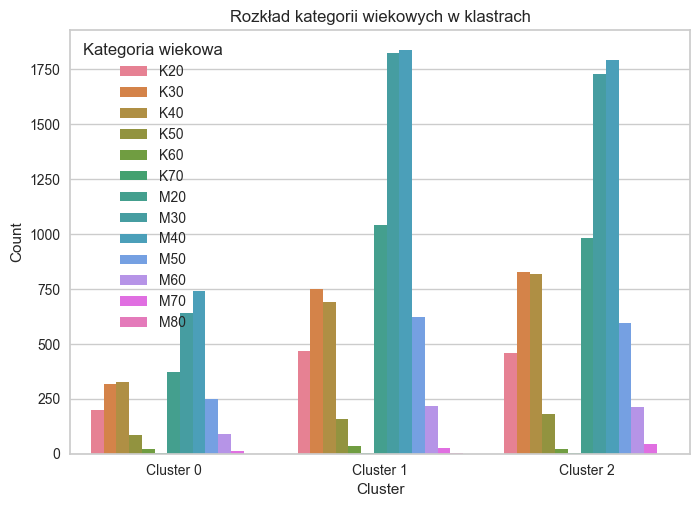

In [199]:
sns.barplot(data=cluster_summary, x='Cluster', y='Count', hue='Kategoria wiekowa')
plt.title('Rozkład kategorii wiekowych w klastrach')
plt.show()

In [200]:
df_joined_2.groupby(['Kategoria wiekowa', "Cluster"]).size().reset_index(name='Count')

Kategoria wiekowa    Cluster  Count
0                K20  Cluster 0    200
1                K20  Cluster 1    467
2                K20  Cluster 2    459
3                K30  Cluster 0    317
4                K30  Cluster 1    752
5                K30  Cluster 2    826
6                K40  Cluster 0    325
7                K40  Cluster 1    689
8                K40  Cluster 2    819
9                K50  Cluster 0     85
10               K50  Cluster 1    160
11               K50  Cluster 2    183
12               K60  Cluster 0     23
13               K60  Cluster 1     37
14               K60  Cluster 2     21
15               K70  Cluster 0      3
16               K70  Cluster 1      5
17               K70  Cluster 2      3
18               M20  Cluster 0    370
19               M20  Cluster 1   1041
20               M20  Cluster 2    982
21               M30  Cluster 0    642
22               M30  Cluster 1   1822
23               M30  Cluster 2   1729
24               M40  Cluster 0    740
25               M40  Cluster 1   1836
26               M40  Cluster 2   1791
27               M50  Cluster 0    248
28               M50  Cluster 1    621
29               M50  Cluster 2    594
30               M60  Cluster 0     89
31               M60  Cluster 1    218
32               M60  Cluster 2    213
33               M70  Cluster 0     11
34               M70  Cluster 1     26
35               M70  Cluster 2     43
36               M80  Cluster 0      1
37               M80  Cluster 1      2

### Niestety takie klastry na pewno nie odzwierciedlają poziomu sportowego zawodnika. 
- Biegacze są pogrupowani w jakiś inny sposób. 
### Powinno być lepiej jeśli normalizację czasu zrobię dla każdej kategorii wiekowej oddzielnie
- Poszukam też jakiej innej metody normalizacji.
- Myślę, że najlepiej będzie w każdej kategorii wiekowej przeliczyć czasy na wartości od 0 do 1.

In [209]:
from sklearn.preprocessing import MinMaxScaler

In [202]:
df_joined_2

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas    Cluster
0                   M30        877          0.031400   3899  Cluster 1
1                   M30        888          0.038000   3983  Cluster 1
2                   M20        946          0.024067   4104  Cluster 1
3                   M30        971          0.025467   4216  Cluster 1
4                   M20        972          0.023000   4227  Cluster 1
...                 ...        ...               ...    ...        ...
18388               K70       2610          0.052148  11987  Cluster 0
18389               K40       2526          0.162733  12068  Cluster 0
18390               K60       2960         -0.029333  12138  Cluster 2
18391               K40       2808          0.057000  12512  Cluster 0
18392               M40       3014         -0.046400  12754  Cluster 1

[18393 rows x 5 columns]

In [203]:
data_normalized = df_joined_2.copy()

data_normalized = data_normalized.drop(columns=['5 km Czas', 'Tempo Stabilność', 'Cluster'])

# Inicjalizujemy scaler
scaler = MinMaxScaler()

# Dzielimy dane na kategorie wiekowe (np. K20, M20, K30, M30...)
for category in df_joined_2['Kategoria wiekowa'].unique():
    category_data = df_joined_2[df_joined_2['Kategoria wiekowa'] == category]
    
    # Normalizujemy tylko kolumnę 'Czas' w obrębie danej kategorii
    data_normalized.loc[data_normalized['Kategoria wiekowa'] == category, 'Czas'] = \
        scaler.fit_transform(category_data[['Czas']])

data_normalized

Kategoria wiekowa      Czas
0                   M30  0.000000
1                   M30  0.010338
2                   M20  0.034401
3                   M30  0.039015
4                   M20  0.050613
...                 ...       ...
18388               K70  0.968697
18389               K40  0.938767
18390               K60  0.957358
18391               K40  1.000000
18392               M40  1.000000

[18393 rows x 2 columns]

In [204]:
MLFLOW_EXPERIMENT_NAME = 'HalfMarathon'
MLFLOW_TAGS = {'data': 'Wroc_23_24', 'library': 'pycaret', 'run_type': 'only_Czas'}

setup(
    data=data_normalized,
    normalize=False,  # Dane są już znormalizowane
    session_id=321,
    log_experiment=True,
    log_plots=True,
    experiment_name=MLFLOW_EXPERIMENT_NAME,
    experiment_custom_tags=MLFLOW_TAGS,
)

Description,Value
Session id,321
Original data shape,"(18393, 2)"
Transformed data shape,"(18393, 14)"
Numeric features,1
Categorical features,1
Preprocess,True
Imputation type,simple
Numeric imputation,mean
Categorical imputation,mode
Maximum one-hot encoding,-1


In [205]:
kmeans_model_time = create_model('kmeans', num_clusters=3)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.4417,5976.5413,1.5997,0,0,0


2025/01/16 13:26:26 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/01/16 13:26:26 INFO mlflow.tracking._tracking_service.client: 🏃 View run K-Means Clustering at: http://localhost:5000/#/experiments/369376800093570612/runs/e3177a7fd6b940a7b663e781c99807ab.
2025/01/16 13:26:26 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/369376800093570612.


In [206]:
clustered_data_2 = assign_model(kmeans_model_time)

In [207]:
# Resetowanie indeksów w obu dataframe'ach
clustered_data_2 = clustered_data_2.reset_index(drop=True)
df_joined_2 = df_joined_2.reset_index(drop=True)

# Przypisanie kolumny 'Cluster' (z klasteryzacji) do danych przed normalizacją
df_joined_2['Cluster'] = clustered_data['Cluster']

In [210]:
df_joined_2

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas    Cluster
0                   M30        877          0.031400   3899  Cluster 1
1                   M30        888          0.038000   3983  Cluster 1
2                   M20        946          0.024067   4104  Cluster 1
3                   M30        971          0.025467   4216  Cluster 1
4                   M20        972          0.023000   4227  Cluster 1
...                 ...        ...               ...    ...        ...
18388               K70       2610          0.052148  11987  Cluster 0
18389               K40       2526          0.162733  12068  Cluster 0
18390               K60       2960         -0.029333  12138  Cluster 2
18391               K40       2808          0.057000  12512  Cluster 0
18392               M40       3014         -0.046400  12754  Cluster 1

[18393 rows x 5 columns]

In [211]:
cluster_summary_2 = df_joined_2.groupby(['Cluster', 'Kategoria wiekowa']).size().reset_index(name='Count')
cluster_summary_2

Cluster Kategoria wiekowa  Count
0   Cluster 0               K20    200
1   Cluster 0               K30    317
2   Cluster 0               K40    325
3   Cluster 0               K50     85
4   Cluster 0               K60     23
5   Cluster 0               K70      3
6   Cluster 0               M20    370
7   Cluster 0               M30    642
8   Cluster 0               M40    740
9   Cluster 0               M50    248
10  Cluster 0               M60     89
11  Cluster 0               M70     11
12  Cluster 0               M80      1
13  Cluster 1               K20    467
14  Cluster 1               K30    752
15  Cluster 1               K40    689
16  Cluster 1               K50    160
17  Cluster 1               K60     37
18  Cluster 1               K70      5
19  Cluster 1               M20   1041
20  Cluster 1               M30   1822
21  Cluster 1               M40   1836
22  Cluster 1               M50    621
23  Cluster 1               M60    218
24  Cluster 1               M70     26
25  Cluster 1               M80      2
26  Cluster 2               K20    459
27  Cluster 2               K30    826
28  Cluster 2               K40    819
29  Cluster 2               K50    183
30  Cluster 2               K60     21
31  Cluster 2               K70      3
32  Cluster 2               M20    982
33  Cluster 2               M30   1729
34  Cluster 2               M40   1791
35  Cluster 2               M50    594
36  Cluster 2               M60    213
37  Cluster 2               M70     43

In [212]:
df_joined_2

Kategoria wiekowa  5 km Czas  Tempo Stabilność   Czas    Cluster
0                   M30        877          0.031400   3899  Cluster 1
1                   M30        888          0.038000   3983  Cluster 1
2                   M20        946          0.024067   4104  Cluster 1
3                   M30        971          0.025467   4216  Cluster 1
4                   M20        972          0.023000   4227  Cluster 1
...                 ...        ...               ...    ...        ...
18388               K70       2610          0.052148  11987  Cluster 0
18389               K40       2526          0.162733  12068  Cluster 0
18390               K60       2960         -0.029333  12138  Cluster 2
18391               K40       2808          0.057000  12512  Cluster 0
18392               M40       3014         -0.046400  12754  Cluster 1

[18393 rows x 5 columns]

### Jednak takie klastrowanie również nie spełnia moich założeń
- Muszę doszkolić się jak działają modele klastrujące.
- Być może trzeba by było spróbować z innymi modelami lub innymi ustawieniami jakiś parametrów.

### Tymczasem przygotuję trochę inną aplikację
- Model AI będzie wyłuskiwał płeć, wiek i poziom sportowy biegacza z krótkiego tekstu wpisanego przez użytkownika.
- Przygotuję dane tak, aby każdą kategorię wiekową podzielić na 10 zakresów czasu ukończenia półmaratonu za pomocą percentyli co 10.
- W takich grupach policzymy średnie czasy ukończenia biegu i na piątym kilometrze.
- Użytkownik aplikacji na podstawie krótkiego zdania o sobie otrzyma informację na jaki może liczyć czas w półmaratonie i jak szybko powinien zacząć bieg.

In [261]:
df_2023 = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathons/halfmarathon_wroclaw_2023__final.csv", sep=";")
df_2024 = pd.read_csv(f"s3://{BUCKET_NAME}/halfmarathons/halfmarathon_wroclaw_2024__final.csv", sep=";")
if list(df_2023.columns) == list(df_2024.columns):
    
    df_joined_2 = pd.concat([df_2023, df_2024], ignore_index=True)
else:
    raise ValueError("Kolumny w DataFrame nie są takie same")
df_joined_2 = df_joined_2.drop(columns=['Miejsce', 'Numer startowy', 'Imię', 'Nazwisko', 'Miasto', 'Kraj',
       'Drużyna', 'Płeć Miejsce', 
       'Kategoria wiekowa Miejsce', 
       '5 km Miejsce Open', '5 km Tempo', '10 km Czas', '10 km Miejsce Open',
       '10 km Tempo', '15 km Czas', '15 km Miejsce Open', '15 km Tempo',
       '20 km Czas', '20 km Miejsce Open', '20 km Tempo', "Tempo"
       ])
df_joined_2 = df_joined_2.dropna(subset=['Czas'])
df_joined_2 = df_joined_2.dropna(subset=['Kategoria wiekowa'])
df_joined_2 = df_joined_2.drop(columns=['Rocznik'])
df_joined_2 = df_joined_2.dropna(subset=['5 km Czas'])
# Oblicz średnią wartość dla kolumny 'Tempo Stabilność', pomijając wartości równe 0.0
mean_stabilonsc = df_joined_2[df_joined_2['Tempo Stabilność'] != 0.0]['Tempo Stabilność'].mean()

# Zastąp wartości 0.0 i NaN w kolumnie 'Tempo Stabilność' średnią wartością
df_joined_2['Tempo Stabilność'] = df_joined_2['Tempo Stabilność'].replace(0.0, mean_stabilonsc)
df_joined_2['Tempo Stabilność'] = df_joined_2['Tempo Stabilność'].fillna(mean_stabilonsc)
for col in ["5 km Czas", "Czas"]:
    df_joined_2[col] = df_joined_2[col].apply(convert_time_to_seconds)



In [262]:
df_dane_biegaczy = df_joined_2.drop(columns=['Płeć', "Tempo Stabilność"])
df_dane_biegaczy

Kategoria wiekowa  5 km Czas   Czas
0                   M30        877   3899
1                   M30        888   3983
2                   M20        946   4104
3                   M30        971   4216
4                   M20        972   4227
...                 ...        ...    ...
19245               K70       2610  11987
19246               K40       2526  12068
19247               K60       2960  12138
19248               K40       2808  12512
19249               M40       3014  12754

[18393 rows x 3 columns]

In [263]:
import pandas as pd
import numpy as np

In [265]:
# Sortowanie danych
df_sorted = df_dane_biegaczy.sort_values(by=['Kategoria wiekowa', 'Czas'])

# Funkcja do przypisywania poziomów wytrenowania
def przypisz_poziom(group):
    group_size = len(group)
    group['Poziom wytrenowania'] = pd.qcut(group['Czas'], 10, labels=False, duplicates='drop')
    group['Poziom wytrenowania'] = 10 - group['Poziom wytrenowania']
    return group

# Grupowanie według kategorii wiekowej i przypisywanie poziomów
df_sorted = df_sorted.groupby('Kategoria wiekowa').apply(przypisz_poziom).reset_index(drop=True)

In [266]:
df_sorted.sample(20)

Kategoria wiekowa  5 km Czas  Czas  Poziom wytrenowania
6483                M20       1689  6991                    6
4588                K40       2142  9193                    2
814                 K20       1833  8653                    3
9848                M30       1578  6945                    6
6745                M20       1619  7224                    5
17492               M50       1907  8142                    3
11619               M30       1968  8780                    1
5422                M20       1193  5098                   10
13128               M40       1512  6369                    8
12461               M40       1370  5873                    9
6960                M20       1804  7529                    4
8331                M30       1288  5847                    9
12164               M40       1273  5410                   10
10246               M30       1670  7177                    5
2474                K30       2010  8478                    3
3945                K40       1807  7922                    5
13891               M40       1514  6815                    6
15007               M40       1742  7525                    4
3450                K40       1655  7139                    8
4333                K40       1907  8541                    3

In [267]:
df_sorted.to_csv('dane_biegaczy.csv', index=False, encoding='utf-8')

In [268]:
df_sorted.to_csv(f"s3://{BUCKET_NAME}/halfmarathons/dane_biegaczy.csv", sep=";", index=False)